# Elastic Net — Plantilla de experimento

**Cómo usar este cuaderno**
1. Edita la celda **CONFIGURACIÓN** con el nombre del experimento, las Ys y las Xs.
2. Corre todas las celdas en orden (`Run All`).
3. Los resultados se exportan automáticamente al directorio configurado.

Cada paso del pipeline vive en `pipeline/stepXX_*.py` y puede modificarse de forma independiente.

In [1]:
import sys
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# ── Rutas del proyecto ────────────────────────────────────────────────────────
# Sube hasta encontrar paths.yml (funciona desde cualquier subdirectorio)
_here = Path().resolve()
_root = _here
while not (_root / 'paths.yml').exists() and _root.parent != _root:
    _root = _root.parent

with open(_root / 'paths.yml') as f:
    _paths = yaml.safe_load(f)

raw       = Path(_paths['data']['raw'])
temp      = Path(_paths['data']['temp'])
processed = Path(_paths['data']['processed'])
model_out = Path(_paths['outputs']['model'])

# ── Importar pipeline ─────────────────────────────────────────────────────────
# El paquete pipeline/ debe estar en el mismo directorio que este notebook
sys.path.insert(0, str(_here))

from pipeline import (
    load_data,
    analyze_target,
    create_temporal_splits,
    prepare_features,
    impute_missing,
    scale_features,
    tune_hyperparameters,
    optimize_threshold,
    evaluate_model,
    get_coefficients,
    export_results,
)

print('✓ Pipeline importado correctamente')

✓ Pipeline importado correctamente


---
## CONFIGURACIÓN
**Edita esta celda antes de correr el experimento.**

In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# IDENTIFICACIÓN DEL EXPERIMENTO
# ─────────────────────────────────────────────────────────────────────────────
EXPERIMENT_NAME = 'elasticnet_mi_modelo'   # Prefijo de los archivos de salida

# ─────────────────────────────────────────────────────────────────────────────
# RUTAS
# ─────────────────────────────────────────────────────────────────────────────
DATA_PATH   = processed / 'db_no_jep.parquet'
RESULTS_DIR = model_out   # Carpeta donde se guardan métricas y coeficientes

# ─────────────────────────────────────────────────────────────────────────────
# COLUMNAS CLAVE
# ─────────────────────────────────────────────────────────────────────────────
TARGET_COL       = 'atypical_violence'  # ← VARIABLE Y
TIME_COL         = 'quarter'            # Formato 'YYYYQN'
MUNICIPALITY_COL = 'mun_code'

# ─────────────────────────────────────────────────────────────────────────────
# SELECCIÓN DE VARIABLES X
#
# OPCIÓN A — Exclusión (se usan todas las columnas EXCEPTO las listadas)
# ─────────────────────────────────────────────────────────────────────────────
COLS_TO_EXCLUDE = [
    # Violencia contemporánea (target leakage)
    'iacv', 'iacv_t', 'qty_iacv',
    'qty_01', 'qty_02', 'qty_03', 'qty_04', 'qty_05',
    # Población absoluta
    'population',
    # Columna técnica de merge
    '_merge',
]
FEATURE_COLS = None   # Si es None se usa COLS_TO_EXCLUDE

# OPCIÓN B — Selección explícita (descomenta y lista tus Xs)
# FEATURE_COLS = [
#     'iacv_r1', 'iacv_r2', 'iacv_r3', 'iacv_r4',
#     'coca', 'amapola',
#     'nbi_2018', 'IPM_2018',
#     'altura', 'discapital',
# ]
# COLS_TO_EXCLUDE = None   # Se ignora cuando FEATURE_COLS está definida

# ─────────────────────────────────────────────────────────────────────────────
# SPLITS TEMPORALES
# ─────────────────────────────────────────────────────────────────────────────
TRAIN_PROP = 0.70
VAL_PROP   = 0.15
TEST_PROP  = 0.15

# Splits por años específicos (descomenta para usar)
# USE_YEAR_SPLITS   = True
# TRAIN_END_YEAR    = 2018 ; TRAIN_END_QUARTER = 4
# VAL_END_YEAR      = 2020 ; VAL_END_QUARTER   = 4
USE_YEAR_SPLITS = False

# ─────────────────────────────────────────────────────────────────────────────
# HIPERPARÁMETROS
# ─────────────────────────────────────────────────────────────────────────────
PARAM_GRID = {
    'C':        [0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
}
N_CV_SPLITS   = 5
CV_SCORING    = 'f1'          # 'f1' | 'average_precision' | 'roc_auc'
RANDOM_STATE  = 42

# ─────────────────────────────────────────────────────────────────────────────
# THRESHOLD
# ─────────────────────────────────────────────────────────────────────────────
THRESHOLD_RANGE    = (0.1, 0.9)
THRESHOLD_STEP     = 0.05
THRESHOLD_METRIC   = 'f1'     # Métrica a maximizar al elegir el threshold

# ─────────────────────────────────────────────────────────────────────────────
# IMPUTACIÓN
# ─────────────────────────────────────────────────────────────────────────────
NUMERIC_STRATEGY      = 'median'
CATEGORICAL_STRATEGY  = 'most_frequent'

print(f'✓ Configuración lista  |  Experimento: {EXPERIMENT_NAME}')
print(f'  Target  : {TARGET_COL}')
print(f'  X mode  : {"explícita" if FEATURE_COLS else "por exclusión"}')
print(f'  Splits  : {TRAIN_PROP:.0%} / {VAL_PROP:.0%} / {TEST_PROP:.0%}')

✓ Configuración lista  |  Experimento: elasticnet_mi_modelo
  Target  : atypical_violence
  X mode  : por exclusión
  Splits  : 70% / 15% / 15%


---
## Paso 1 — Cargar datos

In [3]:
df = load_data(DATA_PATH, time_col=TIME_COL, municipality_col=MUNICIPALITY_COL)
df.head(3)

Cargando datos desde: /Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/data/processed/db_no_jep.parquet
✓ Datos cargados: 76,184 filas × 67 columnas
Rango temporal : 2006Q1 → 2022Q4
Periodos únicos: 68 | Municipios: 1121


,mun_code,quarter,iacv,iacv_t,atypical_violence,iacv_r1,iacv_r2,iacv_r3,iacv_r4,qty_iacv,...,areaoficialkm2,altura,discapital,dismdo,disbogota,distancia_mercado,_merge,año,trimestre,periodo_num
0,05001,2006Q1,1.53,1.809,0,1.63,1.88,1.49,1.55,31.59,...,5287.702842,1475.0,0.000000,0.000000,264.33902,0.000000,both,2006,1,20061
1,05002,2006Q1,2.85,3.791,0,3.57,1.91,3.69,2.64,0.65,...,46.160966,2275.0,58.200874,58.200874,209.00545,16.083084,both,2006,1,20061
2,05004,2006Q1,0.00,3.577,0,0.00,0.00,0.00,4.77,0.00,...,9.279863,1900.0,63.854633,63.854633,326.94080,49.629030,both,2006,1,20061


---
## Paso 2 — Análisis de la variable objetivo

ANÁLISIS DE VARIABLE OBJETIVO: 'atypical_violence'
  Clase 1 (positivo): 14,270  (18.73%)
  Clase 0 (negativo): 61,914  (81.27%)
  Desbalance        : 4.34:1


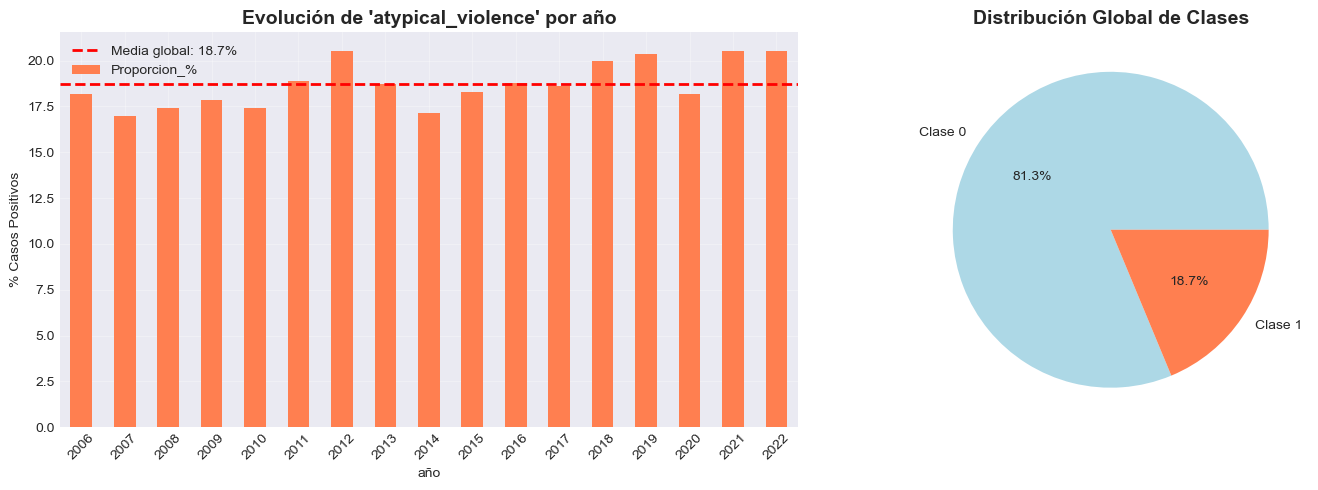

In [4]:
target_stats = analyze_target(df, TARGET_COL, time_group_col='año', plot=True)

---
## Paso 3 — Splits temporales

In [5]:
splits = create_temporal_splits(
    df,
    time_col       = TIME_COL,
    train_prop     = TRAIN_PROP,
    val_prop       = VAL_PROP,
    test_prop      = TEST_PROP,
    use_year_splits = USE_YEAR_SPLITS,
    # Descomenta si USE_YEAR_SPLITS=True:
    # train_end_year=TRAIN_END_YEAR, train_end_quarter=TRAIN_END_QUARTER,
    # val_end_year=VAL_END_YEAR,   val_end_quarter=VAL_END_QUARTER,
)

train_mask = splits['train_mask']
val_mask   = splits['val_mask']
test_mask  = splits['test_mask']

✓ Splits por proporciones (70%/15%/15%):
  Train: 47 periodos  (2006Q1 → 2017Q3)  52,643 obs (69.1%)
  Val  : 10 periodos  (2017Q4 → 2020Q1)  11,210 obs (14.7%)
  Test : 11 periodos  (2020Q2 → 2022Q4)  12,331 obs (16.2%)
✓ Sin overlap


---
## Paso 4 — Preparar features

In [6]:
X, y, feature_cols = prepare_features(
    df,
    target_col       = TARGET_COL,
    municipality_col = MUNICIPALITY_COL,
    time_col         = TIME_COL,
    cols_to_exclude  = COLS_TO_EXCLUDE,
    feature_cols     = FEATURE_COLS,
)

# Aplicar splits
X_train, y_train = X[train_mask].copy(), y[train_mask].copy()
X_val,   y_val   = X[val_mask].copy(),   y[val_mask].copy()
X_test,  y_test  = X[test_mask].copy(),  y[test_mask].copy()

print(f'\nFormas: train={X_train.shape} | val={X_val.shape} | test={X_test.shape}')
for name, yy in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    print(f'  {name}: prevalencia={yy.mean():.2%}')

FEATURES DEL MODELO
  Features seleccionadas : 54
  Target                 : 'atypical_violence'  (prevalencia: 18.73%)

  Variables:
      1. iacv_r1
      2. iacv_r2
      3. iacv_r3
      4. iacv_r4
      5. women_share
      6. coca
      7. amapola
      8. y_corr
      9. y_corr_tribut_IyC
     10. DF_ing_func
     11. DF_deuda
     12. DF_desemp_fisc
     13. s11_total
     14. docen_total
     15. alumn_total
     16. nbi_2005
     17. nbi_2018
     18. IPM_2005
     19. IPM_2018
     20. ipm_ledu_p_2005
     21. ipm_ledu_p_2018
     22. ipm_analf_p_2005
     23. ipm_analf_p_2018
     24. ipm_asisescu_p_2005
     25. ipm_asisescu_p_2018
     26. ipm_rezagoescu_p_2005
     27. ipm_rezagoescu_p_2018
     28. ipm_serv_pinf_p_2005
     29. ipm_serv_pinf_p_2018
     30. ipm_ti_p_2005
     31. ipm_ti_p_2018
     32. ipm_templeof_p_2005
     33. ipm_templeof_p_2018
     34. ipm_assalud_p_2005
     35. ipm_assalud_p_2018
     36. ipm_accsalud_p_2005
     37. ipm_accsalud_p_2018
     38

---
## Paso 5 — Imputación

In [7]:
X_train, X_val, X_test, imputers = impute_missing(
    X_train, X_val, X_test,
    numeric_strategy     = NUMERIC_STRATEGY,
    categorical_strategy = CATEGORICAL_STRATEGY,
)

Columnas numéricas: 54 | Categóricas: 0
Valores faltantes en train: 0
✓ Sin valores faltantes, no se requiere imputación
NaNs restantes: 0


---
## Paso 6 — Estandarización

In [8]:
X_train_sc, X_val_sc, X_test_sc, scaler = scale_features(
    X_train, X_val, X_test, feature_cols
)

✓ Estandarización sin leakage
  Verificación train → Media ~0: 3.02e-15 | Std ~1: 9.50e-06


---
## Paso 7 — Búsqueda de hiperparámetros

In [9]:
import pandas as pd

X_tv = pd.concat([X_train_sc, X_val_sc])
y_tv = pd.concat([y_train, y_val])

best_model, cv_results = tune_hyperparameters(
    X_tv, y_tv,
    param_grid   = PARAM_GRID,
    n_cv_splits  = N_CV_SPLITS,
    scoring      = CV_SCORING,
    random_state = RANDOM_STATE,
)

GridSearchCV: 30 combinaciones × 5 folds | métrica: f1
Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 

---
## Paso 8 — Optimización de threshold

In [ ]:
best_threshold, threshold_df = optimize_threshold(
    best_model, X_val_sc, y_val,
    threshold_range  = THRESHOLD_RANGE,
    threshold_step   = THRESHOLD_STEP,
    optimize_metric  = THRESHOLD_METRIC,
    plot             = True,
)

---
## Paso 9 — Evaluación en test

In [ ]:
metrics, y_test_proba, y_test_pred = evaluate_model(
    best_model, X_test_sc, y_test,
    threshold = best_threshold,
    plot      = True,
)

---
## Paso 10 — Interpretabilidad

In [ ]:
coeficientes = get_coefficients(best_model, feature_cols, top_n=20, plot=True)

---
## Paso 11 — Exportar resultados

In [ ]:
extra = {
    'n_features':      len(feature_cols),
    'train_size':      len(y_train),
    'val_size':        len(y_val),
    'test_size':       len(y_test),
    'train_prev':      float(y_train.mean()),
    'val_prev':        float(y_val.mean()),
    'test_prev':       float(y_test.mean()),
    'best_C':          best_model.C,
    'best_l1_ratio':   best_model.l1_ratio,
    'cv_scoring':      CV_SCORING,
    'target_col':      TARGET_COL,
}

output_paths = export_results(
    results_dir     = RESULTS_DIR,
    experiment_name = EXPERIMENT_NAME,
    metrics         = metrics,
    coeficientes    = coeficientes,
    extra_info      = extra,
)